input:
- seg masks shape file
- image tiff file

output:
- labeled masks shape file

In [5]:
import geopandas as gpd
from shapely.geometry import mapping
import rasterio
from rasterio.features import geometry_mask
import numpy as np
from sklearn.cluster import DBSCAN
import torch
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image

# Load a pre-trained model (e.g., ResNet-50)
model = models.resnet50(pretrained=True)
model.eval()  # Set to evaluation mode

# Define a transformation to apply to image patches
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to extract image patches within a polygon
def extract_polygon_patch(polygon, image_data, transform):
    # Create a 2D mask for the polygon
    mask = geometry_mask([mapping(polygon)], transform=transform, invert=True, out_shape=image_data.shape[1:])
    
    # Apply the mask to each band of the image
    masked_data = np.zeros_like(image_data[:3])
    for i in range(3):
        masked_data[i] = image_data[i] * mask
    
    # Crop the masked data to the bounding box of the polygon
    bounds = polygon.bounds
    window = rasterio.windows.from_bounds(*bounds, transform=transform)
    patch = masked_data[:, window.toslices()[0], window.toslices()[1]]
    
    # Convert the patch to a PIL Image for further processing
    patch = np.moveaxis(patch, 0, -1)  # Change shape from (bands, height, width) to (height, width, bands)
    patch = Image.fromarray(patch.astype(np.uint8))
    
    return patch

# Function to extract features from an image patch
def extract_features(patch):
    image = transform(patch).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        features = model(image)
    return features.squeeze().numpy()  # Remove batch dimension

# Read the polygon shapefile
polygons = gpd.read_file('h:\\Yehmh\\DNDF\\101_1_focus\\202404_101_seg_shp_labeled\\DNDF101_clip_seg_labeled.shp')
tif_file = 'h:\\Yehmh\\DNDF\\101_1_focus\\DNDF101_clip.tif'

# Open the TIF file
with rasterio.open(tif_file) as src:
    image_data = src.read()

# List to store features for each polygon
polygon_features = []

# Extract features for each polygon
for polygon in polygons.geometry:
    patch = extract_polygon_patch(polygon, image_data, src.transform)
    if patch.getbbox() is not None:  # Check if the patch is not emptyv
        features = extract_features(patch)
        polygon_features.append(features)
    else:
        polygon_features.append(np.zeros(2048))  # Placeholder for empty patches

# Perform clustering on the extracted features
features_array = np.array(polygon_features)
dbscan = DBSCAN(eps=0.5, min_samples=5)
cluster_labels = dbscan.fit_predict(features_array)

# Add cluster labels to the GeoDataFrame
polygons['cluster'] = cluster_labels

# Save the new shapefile with cluster information
polygons.to_file('h:\\Yehmh\\DNDF\\101_1_focus\\202404_101_seg_shp_labeled_clustered\\DNDF101_clip_seg_labeled_DBSCAN_ResNet50.shp')


c:\Users\user\.conda\envs\RS\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\.conda\envs\RS\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
import geopandas as gpd
from shapely.geometry import mapping
import rasterio
from rasterio.features import geometry_mask
import numpy as np
from sklearn.cluster import DBSCAN
import torch
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image

# Check if a GPU is available and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load a pre-trained model (e.g., ResNet-50)
model = models.resnet50(pretrained=True)
model.eval()  # Set to evaluation mode

# Define a transformation to apply to image patches
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_polygon_patch(polygon, image_data, transform):
    """Extract image patch within a polygon"""
    mask = geometry_mask([mapping(polygon)], transform=transform, invert=True, out_shape=image_data.shape[1:])
    masked_data = np.zeros_like(image_data[:3])
    for i in range(3):
        masked_data[i] = image_data[i] * mask
    bounds = polygon.bounds
    window = rasterio.windows.from_bounds(*bounds, transform=transform)
    patch = masked_data[:, window.toslices()[0], window.toslices()[1]]
    patch = np.moveaxis(patch, 0, -1)
    patch = Image.fromarray(patch.astype(np.uint8))
    return patch

def extract_features(patch, model, transform):
    """Extract features from an image patch"""
    image = transform(patch).unsqueeze(0)
    with torch.no_grad():
        features = model(image)
    return features.squeeze().numpy()

def perform_clustering(features_array, eps=0.7, min_samples=5):
    """Perform DBSCAN clustering on extracted features"""
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    return dbscan.fit_predict(features_array)

def process_shapefile(shapefile_path, tif_file_path, output_shapefile_path, model, transform):
    """Process shapefile to extract patches, features, and perform clustering"""
    polygons = gpd.read_file(shapefile_path)
    with rasterio.open(tif_file_path) as src:
        image_data = src.read()

    polygon_features = []
    for polygon in polygons.geometry:
        patch = extract_polygon_patch(polygon, image_data, src.transform)
        if patch.getbbox() is not None:
            features = extract_features(patch, model, transform)
            polygon_features.append(features)
        else:
            print(f"Unexpected feature shape: {features.shape}")
            polygon_features.append(np.zeros(2048))

    features_array = np.array(polygon_features)
    cluster_labels = perform_clustering(features_array)
    polygons['cluster'] = cluster_labels
    polygons.to_file(output_shapefile_path)
    return polygons



c:\Users\user\.conda\envs\RS\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\.conda\envs\RS\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Example usage
shapefile_path = 'h:\\Yehmh\\DNDF\\101_1_focus\\202404_101_seg_shp_labeled\\DNDF101_clip_seg_labeled.shp'
tif_file_path = 'h:\\Yehmh\\DNDF\\101_1_focus\\DNDF101_clip.tif'
output_shapefile_path = 'h:\\Yehmh\\DNDF\\101_1_focus\\202404_101_seg_shp_labeled_clustered\\DNDF101_clip_seg_labeled_DBSCAN_ResNet50_test.shp'

clustered_polygons = process_shapefile(shapefile_path, tif_file_path, output_shapefile_path, model, transform)

In [ ]:
# Example usage
shapefile_path = 'h:\\Yehmh\\DNDF\\202404_DNDF\\seg_merged\merged_seg_masks.shp'
tif_file_path = 'h:\\Yehmh\DNDF\\202404_DNDF\\DNDF_merge.tif'
output_shapefile_path = 'h:\\Yehmh\DNDF\\202404_DNDF\\transects_DBSCAN_ResNet50\\transects_DBSCAN_ResNet50.shp'

clustered_polygons = process_shapefile(shapefile_path, tif_file_path, output_shapefile_path, model, transform)

c:\Users\user\.conda\envs\RS\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\.conda\envs\RS\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


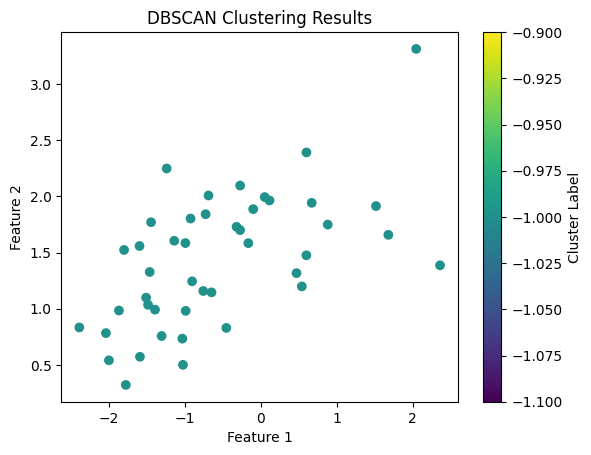

In [16]:
import geopandas as gpd
from shapely.geometry import mapping
import rasterio
from rasterio.features import geometry_mask
import numpy as np
from sklearn.cluster import DBSCAN
import torch
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# Check if a GPU is available and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load a pre-trained model (e.g., ResNet-50) and move it to the GPU
model = models.resnet50(pretrained=True).to(device)
model.eval()  # Set to evaluation mode

# Define a transformation to apply to image patches
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_polygon_patch(polygon, image_data, transform):
    """Extract image patch within a polygon"""
    mask = geometry_mask([mapping(polygon)], transform=transform, invert=True, out_shape=image_data.shape[1:])
    masked_data = np.zeros_like(image_data[:3])
    for i in range(3):
        masked_data[i] = image_data[i] * mask
    bounds = polygon.bounds
    window = rasterio.windows.from_bounds(*bounds, transform=transform)
    patch = masked_data[:, window.toslices()[0], window.toslices()[1]]
    patch = np.moveaxis(patch, 0, -1)
    patch = Image.fromarray(patch.astype(np.uint8))
    return patch

def extract_features(patch, model, transform, device):
    """Extract features from an image patch"""
    image = transform(patch).unsqueeze(0).to(device)  # Move the image tensor to the GPU
    with torch.no_grad():
        features = model(image)
    return features.squeeze().cpu().numpy()  # Move the features back to the CPU and convert to numpy array

def perform_clustering(features_array, eps=0.5, min_samples=5):
    """Perform DBSCAN clustering on extracted features"""
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    return dbscan.fit_predict(features_array)

def process_shapefile(shapefile_path, tif_file_path, output_shapefile_path, model, transform, device, eps, min_samples):
    """Process shapefile to extract patches, features, and perform clustering"""
    polygons = gpd.read_file(shapefile_path)
    with rasterio.open(tif_file_path) as src:
        image_data = src.read()

    polygon_features = []
    for polygon in polygons.geometry:
        patch = extract_polygon_patch(polygon, image_data, src.transform)
        if patch.getbbox() is not None:
            features = extract_features(patch, model, transform, device)
            polygon_features.append(features)
        else:
            print(f"Unexpected feature shape: {features.shape}")
            polygon_features.append(np.zeros(2048))

    features_array = np.array(polygon_features)
    cluster_labels = perform_clustering(features_array, eps=eps, min_samples=min_samples)
    polygons['cluster'] = cluster_labels
    polygons.to_file(output_shapefile_path)
    return polygons, features_array, cluster_labels

# Example usage
shapefile_path = 'h:\\Yehmh\\DNDF\\101_1_focus\\202404_101_seg_shp_labeled\\DNDF101_clip_seg_labeled.shp'
tif_file_path = 'h:\\Yehmh\\DNDF\\101_1_focus\\DNDF101_clip.tif'
output_shapefile_path = 'h:\\Yehmh\\DNDF\\101_1_focus\\202404_101_seg_shp_labeled_clustered\\DNDF101_clip_seg_labeled_DBSCAN_ResNet50.shp'

# Experiment with different eps and min_samples values
eps_value = 0.3  # Try different values
min_samples_value = 5  # Try different values

clustered_polygons, features_array, cluster_labels = process_shapefile(
    shapefile_path, tif_file_path, output_shapefile_path, model, transform, device, eps_value, min_samples_value)

# Visualize the clusters
plt.scatter(features_array[:, 0], features_array[:, 1], c=cluster_labels, cmap='viridis')
plt.title('DBSCAN Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()
